## Characterize obstacle inputs 
Jenna Ruzekowicz (jenna.ruzekowicz@nrel.gov), Caleb Phillips (caleb.phillips@nrel.gov), and Dmitry Duplyakin (dmitry.duplyakin@nrel.gov)

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
import matplotlib.pyplot as plt
from dw_tap.lom import run_lom
import os
import seaborn as sns
from dw_tap.data_processing import _LatLon_To_XY
from shapely.geometry import Polygon, Point, MultiPolygon
from shapely.ops import unary_union

%matplotlib inline
%config InlineBackend.figure_format='retina'

/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
index = pd.read_csv("01 Bergey Turbine Data/bergey_sites.csv")
index.head()

,APRS ID,AID,Public Site Name,Internal Site Name,State,Latitude,Longitude,Hub Height (m),Lidar Quality,Lidar Collection Year,Site Type,Site Notes,Building Data Quality,Turbine,Periods with Consistent Generation Data,Met Tower Data,Met Tower Latitude,Met Tower Longitude,Measurement Height (m),Measurement Privacy
0,t007,A2719,Fremont,Fremont,MN,43.918622,-91.899498,41.0,N/A (Legacy Data),NaN,Rural,No lidar data. This turbine is absolutely surr...,"Partial, some missing",Bergey Excel 10,2012/01 - 2013/12 (outage starting mid-2013/11...,mn_prairiestar.PROPRIETARY.pruf.csv,43.673,-92.698,"30, 50",Proprietary
1,t024,A2672,Washoe,Thomas Danzinger,NV,39.331088,-119.820234,30.0,QL1,2020.0,Rural/Suburban,Straight forward high desert site outside Reno...,Good coverage,Bergey Excel 10,2011/01 - 2022/12,NaN,NaN,NaN,NaN,NaN
2,t028,A3479,Towamensing,Derr,PA,40.851353,-75.598395,30.0,QL2,2019.0,Suburban,Impressive amount of vegetation – some section...,"Partial, some missing",Bergey Excel 10,2011/01 - 2022/12,NaN,NaN,NaN,NaN,NaN
3,t034,A2715,Lycoming,Dan Poor,NY,43.524158,-76.372290,31.0,QL2,2018.0,Rural,"Lakeshore, heavily forested.",Good coverage,Bergey Excel 10,"2013/01 - 2017/12, 2019/01 - 2021/12",ny_oswego,43.464,-76.511,15,Public
4,t041,A2272,Rockford,Fossil Park,IA,43.047418,-92.981674,37.0,QL2,2020.0,Rural,"Very simple site, one building and a couple sm...",Good coverage,Bergey Excel 10,"2013/01 - 2013/12, 2015/01 - 2022/12",NaN,NaN,NaN,NaN,NaN


### Select which sites need to be processed and wind data source

In [3]:
# Small test with several sites
#selected = ["t133", "t135"]

# Process all sites:
selected = index["APRS ID"].tolist()

# Remove 2 sites that currently don't have obstacle descriptions with the heights based on lidar data
selected = [x for x in selected if not(x in ["t007", "t074"])]
print(selected)

wind_sources = ["wtk", "wtk_led_2019"] # One of: ["wtk", "wtk_led_2018", "wtk_led_2019"]

['t024', 't028', 't034', 't041', 't083', 't114', 't133', 't135', 't139', 't140', 't169', 't170', 't182', 't183', 't192', 't207', 't221', nan, nan, nan]


### Load obstacle data

In [4]:
def filter_obstacles(obstacle_df):
    selected = obstacle_df[obstacle_df["height_median"] > 1.0].copy().reset_index(drop=True)
    selected["height"] = selected["height_median"]
    return selected[["height", "geometry"]]

obstacle_specs = pd.DataFrame(columns=["tid", \
                                       "Number of obstacles", \
                                       "Distance to closest obstacle, m", \
                                       "Height of the closest obstacle, m",
                                       "Site Type"])
for tid in selected:
    obstacle_data_dir = "01 Bergey Turbine Data/3dbuildings_geojson"
    obstacle_data_file = "%s/%sv2.json" % (obstacle_data_dir, tid)
    if os.path.exists(obstacle_data_file):
        obstacle_df = filter_obstacles(gpd.read_file(obstacle_data_file))
        
        row = index[index["APRS ID"] == tid].iloc[0]
        lat = row["Latitude"]
        lon = row["Longitude"]
        turbine_point = Point(_LatLon_To_XY(lat, lon))
        stype = row["Site Type"]

        # This will overwrite lat/lon's with coords in meters (for distance calculation)
        for idx, row in obstacle_df.iterrows():
            obstacle_df.at[idx, "geometry"] = Polygon([Point(_LatLon_To_XY(p[1], p[0])) for p in row["geometry"].exterior.coords])
        #display(obstacle_df)
        
        dist_series = obstacle_df.distance(turbine_point)
        min_dist_idx = dist_series.idxmin()
        min_dist_m = dist_series[min_dist_idx]
        closest_obs_height_m = obstacle_df.at[min_dist_idx, "height"]
        
        obstacle_specs.loc[len(obstacle_specs)] = [tid, len(obstacle_df), min_dist_m, closest_obs_height_m, stype]
    else:
        print("Can't access: %s. Skipping" % obstacle_data_file)
    #break
display(obstacle_specs)

/var/folders/j_/dq5lhppd2jlb45qt4fw_cqth59pwpf/T/ipykernel_33882/810760309.py:28: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dist_series = obstacle_df.distance(turbine_point)
/var/folders/j_/dq5lhppd2jlb45qt4fw_cqth59pwpf/T/ipykernel_33882/810760309.py:28: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dist_series = obstacle_df.distance(turbine_point)
/var/folders/j_/dq5lhppd2jlb45qt4fw_cqth59pwpf/T/ipykernel_33882/810760309.py:28: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dist_series = obstacle_df.distance(turbine_point)
/var/folders/j_/dq5lhppd2jlb45qt4fw_cqth59p

Can't access: 01 Bergey Turbine Data/3dbuildings_geojson/nanv2.json. Skipping
Can't access: 01 Bergey Turbine Data/3dbuildings_geojson/nanv2.json. Skipping
Can't access: 01 Bergey Turbine Data/3dbuildings_geojson/nanv2.json. Skipping


/var/folders/j_/dq5lhppd2jlb45qt4fw_cqth59pwpf/T/ipykernel_33882/810760309.py:28: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dist_series = obstacle_df.distance(turbine_point)


,tid,Number of obstacles,"Distance to closest obstacle, m","Height of the closest obstacle, m",Site Type
0,t024,84,7.703934,2.389771,Rural/Suburban
1,t028,154,4.858824,3.521271,Suburban
2,t034,50,11.336468,1.371494,Rural
3,t041,16,40.853890,6.299988,Rural
4,t083,36,28.715042,1.425018,Rural
5,t114,18,15.132590,4.829590,Rural/Suburban
6,t133,12,18.380200,17.100159,Rural
7,t135,14,43.895377,5.119995,Rural
8,t139,10,3.099266,3.429993,Rural
9,t140,259,8.292909,1.580000,Suburban


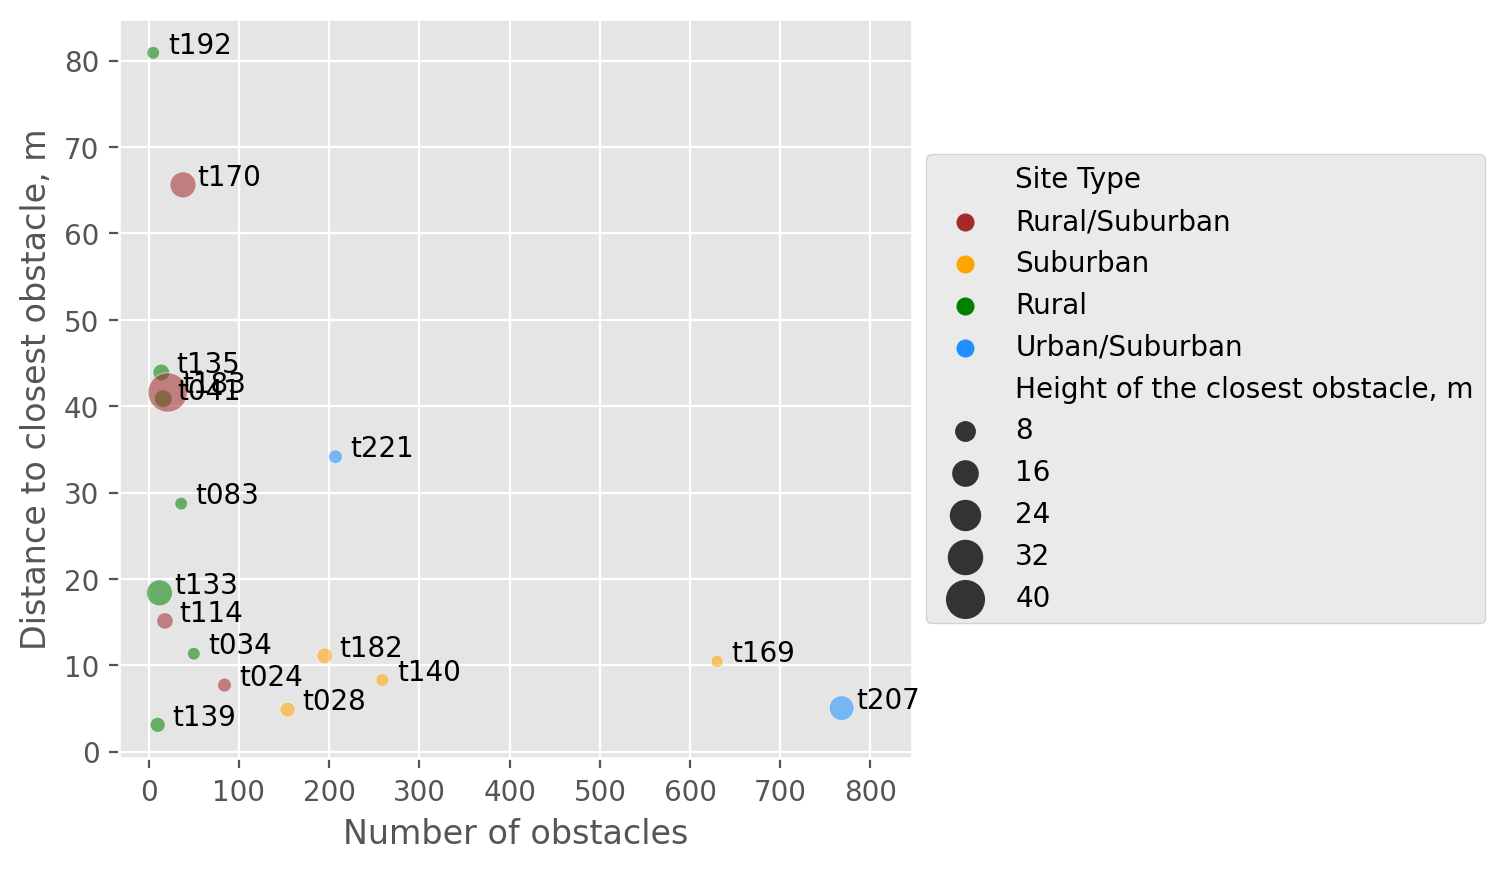

In [5]:
plt.style.use('ggplot')

sns.scatterplot(data=obstacle_specs, \
                x="Number of obstacles", \
                y="Distance to closest obstacle, m",\
                size="Height of the closest obstacle, m",
                sizes=(20, 200),
                hue="Site Type",
                alpha=0.55,
                palette=['brown', 'orange', 'green','dodgerblue']
               );

def label_points(x, y, val, ax):
    xlim = ax.get_xlim()[1]
    offset = xlim / 50  # express offest as a fraction of width
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'] + offset, point['y'], str(point['val']))
# Increase x axis limit to help include the label for the rightmost point
ax = plt.gca()
label_points(obstacle_specs["Number of obstacles"], \
            obstacle_specs["Distance to closest obstacle, m"], \
            obstacle_specs.tid, \
            ax)  
xlim = ax.get_xlim()
ax.set_xlim(xlim[0], xlim[1] * 1.05);

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

### Create a different vis with # of obstacles and their total area (all within 200m radius)

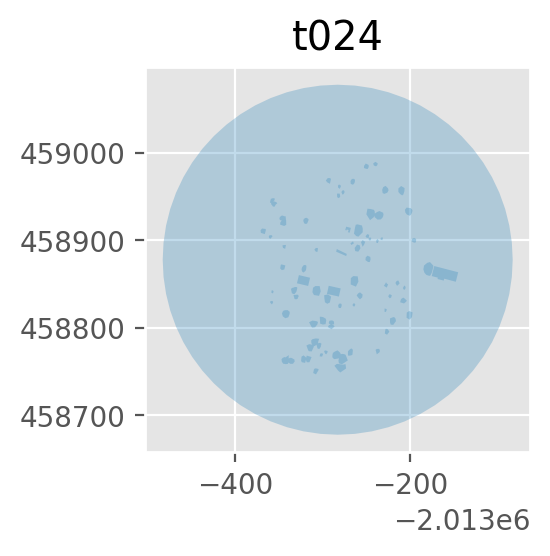

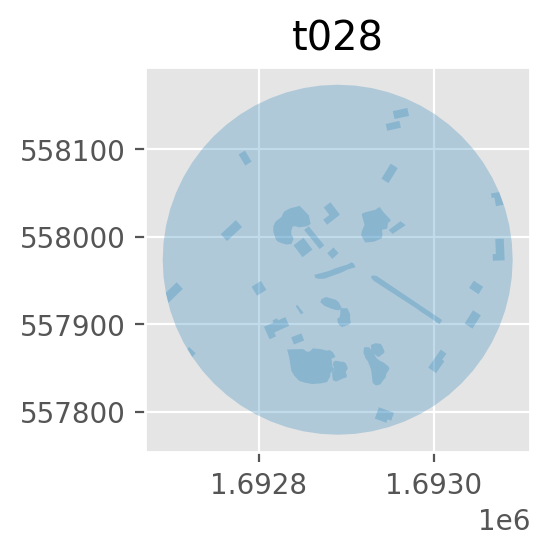

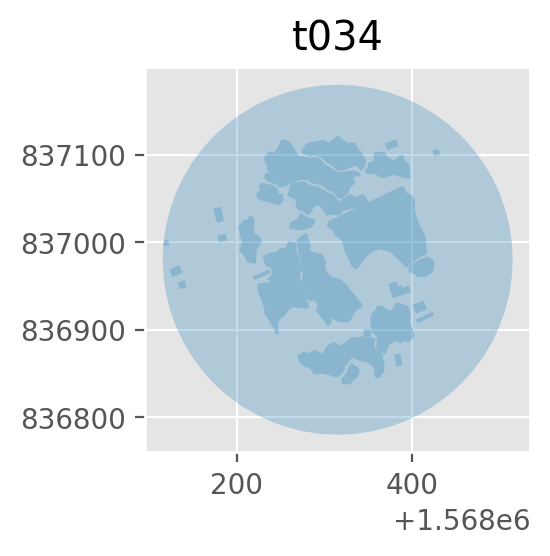

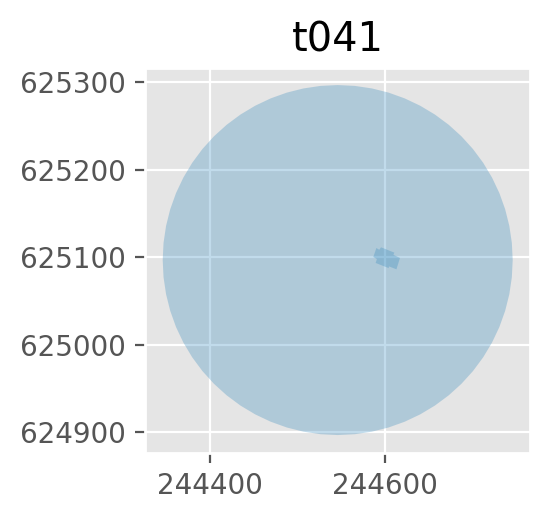

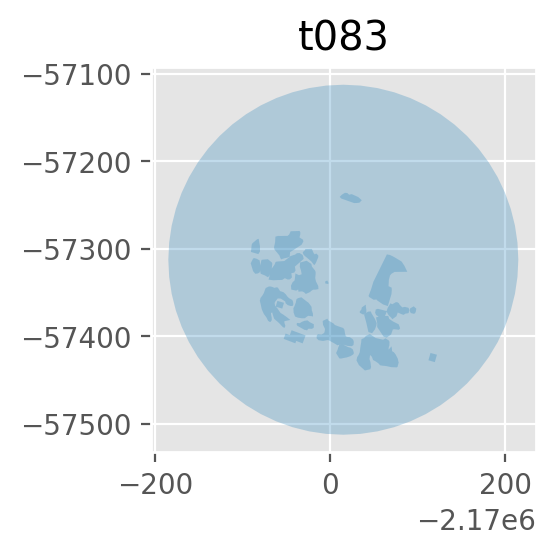

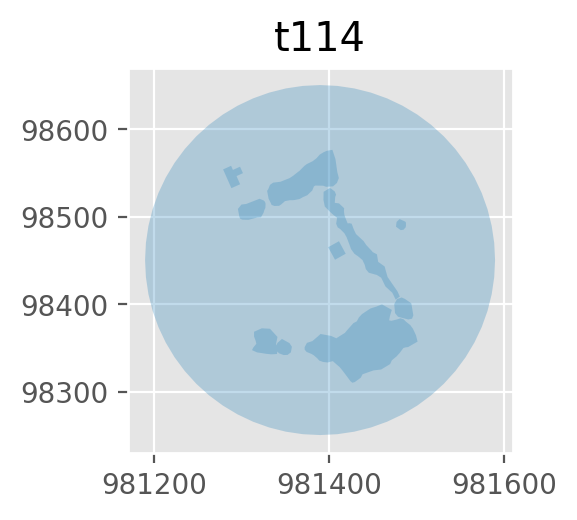

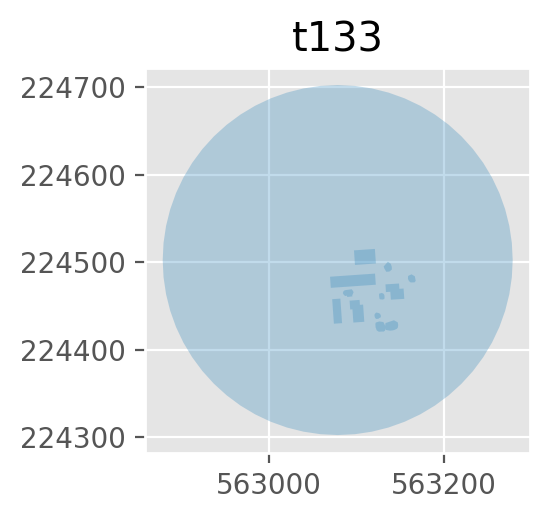

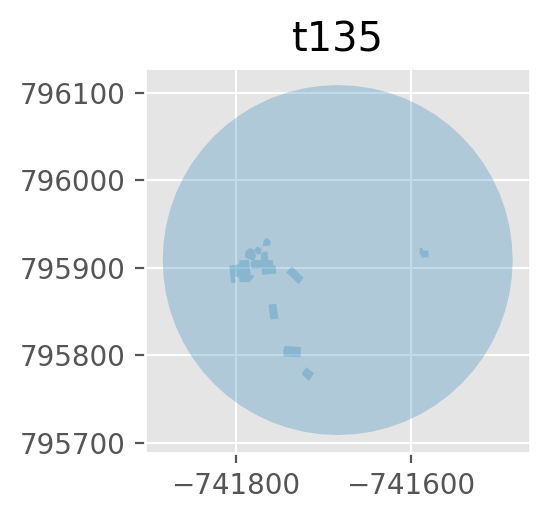

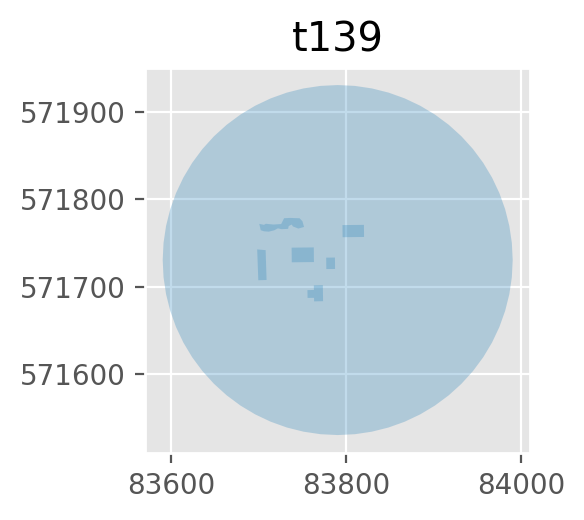

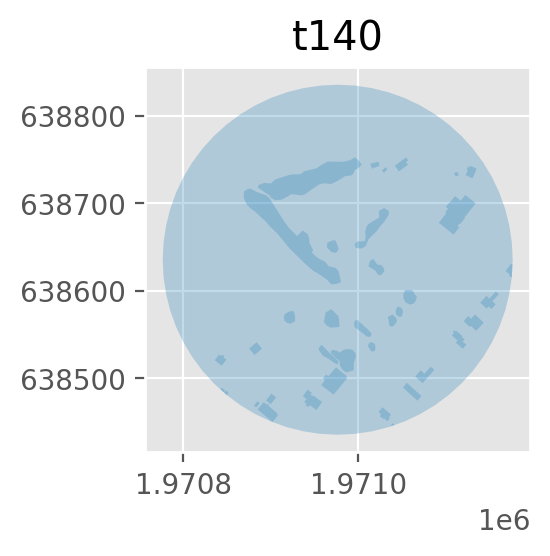

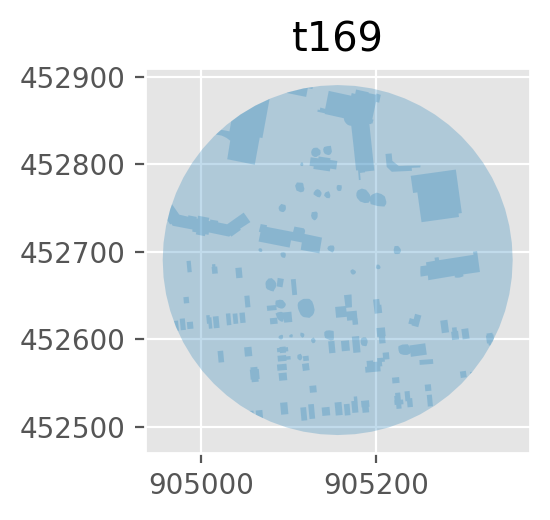

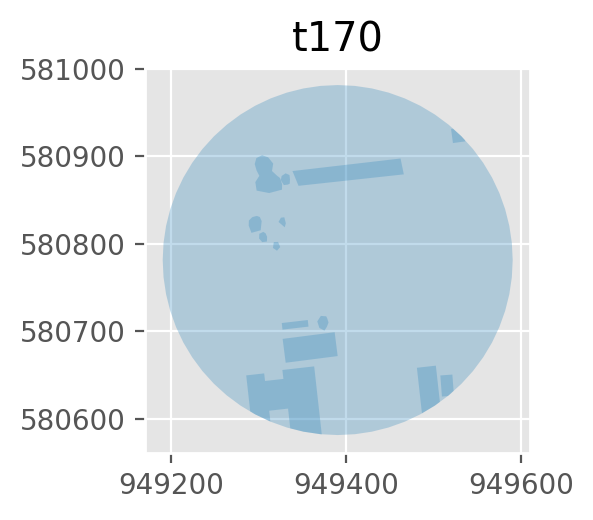

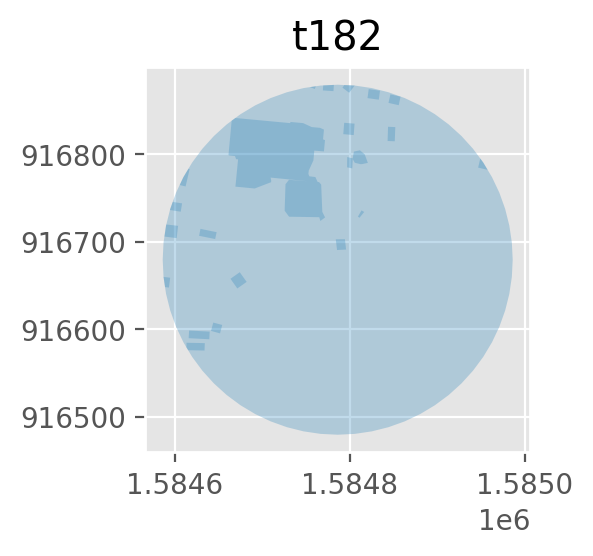

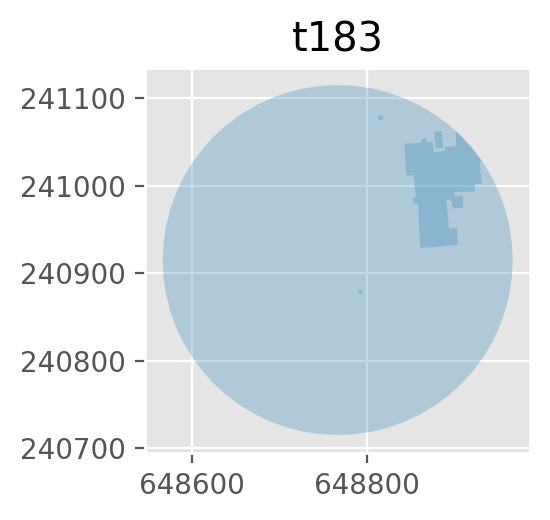

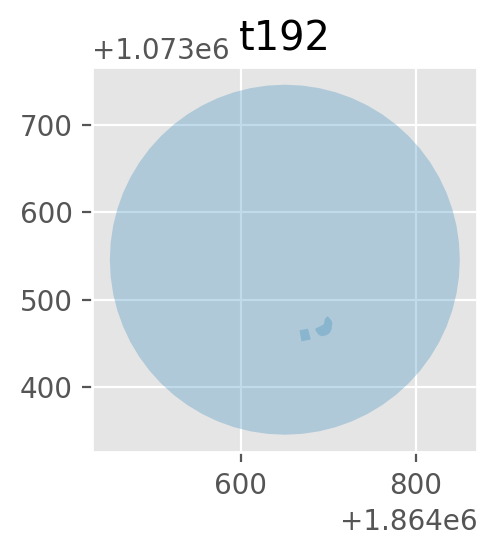

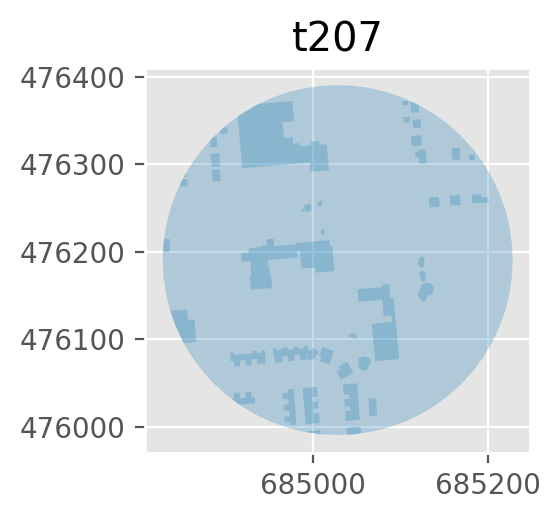

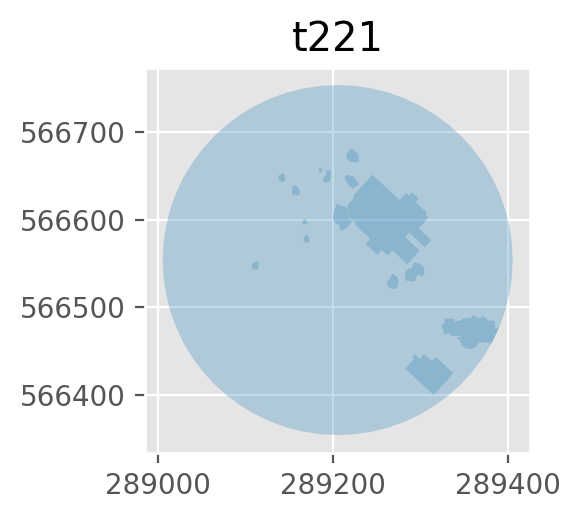

Can't access: 01 Bergey Turbine Data/3dbuildings_geojson/nanv2.json. Skipping
Can't access: 01 Bergey Turbine Data/3dbuildings_geojson/nanv2.json. Skipping
Can't access: 01 Bergey Turbine Data/3dbuildings_geojson/nanv2.json. Skipping


,tid,Number of obstacles (within 200m),Total area of obstacles (within 200m),Site Type
0,t024,69,3237.768700,Rural/Suburban
1,t028,29,9978.304666,Suburban
2,t034,22,30010.205808,Rural
3,t041,1,476.472689,Rural
4,t083,18,9084.192970,Rural
5,t114,9,12581.802879,Rural/Suburban
6,t133,11,2485.723349,Rural
7,t135,9,1961.701693,Rural
8,t139,6,1909.427758,Rural
9,t140,38,11043.258960,Suburban


In [6]:
def filter_obstacles(obstacle_df):
    selected = obstacle_df[obstacle_df["height_median"] > 1.0].copy().reset_index(drop=True)
    selected["height"] = selected["height_median"]
    return selected[["height", "geometry"]]

obstacle_specs = pd.DataFrame(columns=["tid", \
                                       "Number of obstacles (within 200m)", \
                                       "Total area of obstacles (within 200m)", \
                                       "Site Type"])
for tid in selected:
    obstacle_data_dir = "01 Bergey Turbine Data/3dbuildings_geojson"
    obstacle_data_file = "%s/%sv2.json" % (obstacle_data_dir, tid)
    if os.path.exists(obstacle_data_file):
        obstacle_df = filter_obstacles(gpd.read_file(obstacle_data_file))
        
        row = index[index["APRS ID"] == tid].iloc[0]
        lat = row["Latitude"]
        lon = row["Longitude"]
        turbine_point = Point(_LatLon_To_XY(lat, lon))
        turbine_point_200m = turbine_point.buffer(200)
        stype = row["Site Type"]

        # This will overwrite lat/lon's with coords in meters (for distance calculation)
        for idx, row in obstacle_df.iterrows():
            obstacle_df.at[idx, "geometry"] = Polygon([Point(_LatLon_To_XY(p[1], p[0])) for p in row["geometry"].exterior.coords])
        #display(obstacle_df)
        
        u = unary_union([p.intersection(turbine_point_200m) for p in obstacle_df.geometry])
        boundary = gpd.GeoSeries(u)
        boundary[1] = turbine_point_200m
        boundary.plot(alpha=0.3, figsize=(2.5, 2.5)).set_title(tid)
        plt.show()
        
        if type(u) == MultiPolygon:
            obstacle_count = len(u.geoms)
        else:
            # assume single polygon
            obstacle_count = 1
        obstacle_specs.loc[len(obstacle_specs)] = [tid, obstacle_count, u.area, stype]
    else:
        print("Can't access: %s. Skipping" % obstacle_data_file)

display(obstacle_specs)

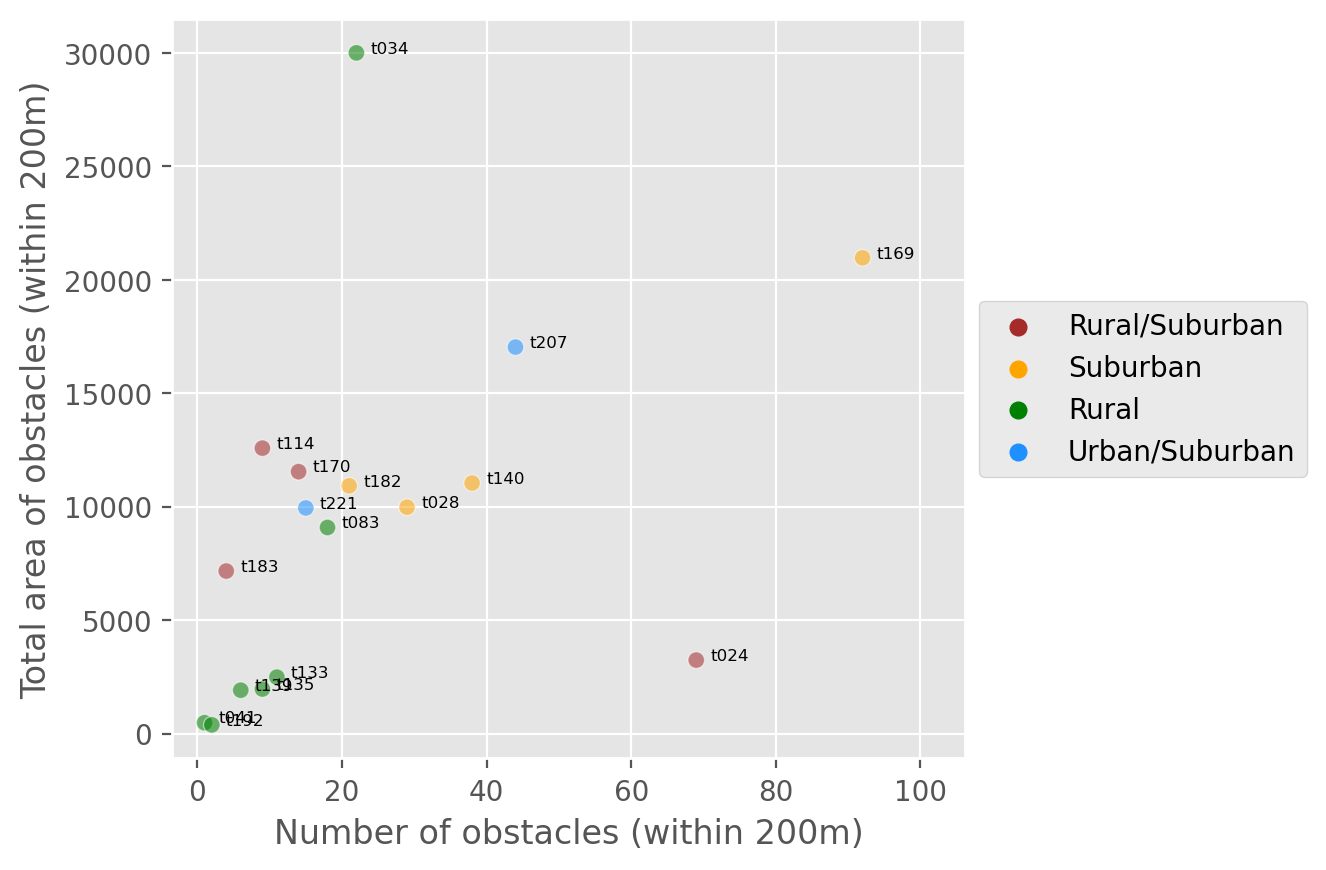

In [7]:
plt.style.use('ggplot')

sns.scatterplot(data=obstacle_specs, \
                x="Number of obstacles (within 200m)", \
                y="Total area of obstacles (within 200m)",\
                hue="Site Type",
                alpha=0.55,
                palette=['brown', 'orange', 'green','dodgerblue']
               );

def label_points(x, y, val, ax):
    xlim = ax.get_xlim()[1]
    offset = xlim / 50  # express offest as a fraction of width
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'] + offset, point['y'], str(point['val']), fontsize=6.0)
# Increase x axis limit to help include the label for the rightmost point
ax = plt.gca()
label_points(obstacle_specs["Number of obstacles (within 200m)"], \
            obstacle_specs["Total area of obstacles (within 200m)"], \
            obstacle_specs.tid, \
            ax)  
xlim = ax.get_xlim()
ax.set_xlim(xlim[0], xlim[1] * 1.10);

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()